In [1]:
import sys
print(sys.executable)
FILE_NAME = 'cvTeste'

c:\Users\guiga\Documents\ZapRecap\fastapi-backend\venv\Scripts\python.exe


In [2]:
import calendar
from collections import Counter, defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re

def is_new_message(line):
    # Check if line starts with date pattern DD/MM/YYYY HH:MM
    date_pattern = r'^\d{2}/\d{2}/\d{4} \d{2}:\d{2}'
    return bool(re.match(date_pattern, line))

def parse_line(line):
    # Split line into date and message
    date, message = line.split(' - ', 1)
    date = datetime.strptime(date, '%d/%m/%Y %H:%M')
    return date, message

def parse_message(message):
    # Split message into author and content
    try:
        author, content = message.split(': ', 1)
        return author, content
    except ValueError:
        return None, None

def store_message(messages, date, author, content):
    # Store message in messages dictionary
    try:
        messages[author].append((date, content))
    except KeyError:
        messages[author] = [(date, content)]
    except TypeError:
        pass


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
dates = []
author_and_messages = {}
current_author = None
current_message = None

with open(f'C:\\Users\\guiga\\Documents\\ZapRecap\\test\\{FILE_NAME}.txt', 'r', encoding='utf-8') as file:
    # Skip first line (default WhatsApp messages)
    next(file)

    date, message = parse_line(next(file))
    dates.append(date)
    current_author, current_message = parse_message(message)

    for line in file:
        line = line.strip()
        if is_new_message(line):
            store_message(author_and_messages, date, current_author, current_message)
            date, message = parse_line(line)
            dates.append(date)
            current_author, current_message = parse_message(message)
        else:
            current_message += ' ' + line
            
    # Store last message
    store_message(author_and_messages, date, current_author, current_message)
        

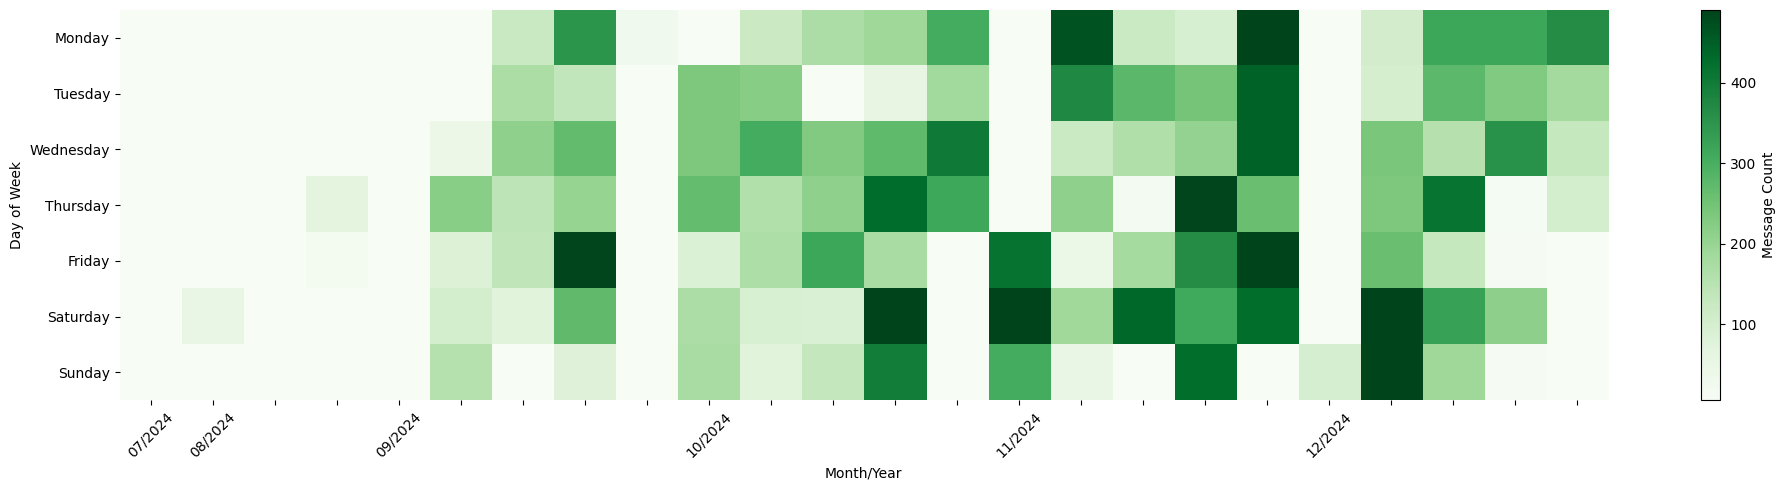

In [4]:
# Create DataFrame from dates list
df = pd.DataFrame({'datetime': dates})

# Add necessary columns for heatmap
df['weekday'] = df['datetime'].dt.dayofweek
df['month_year'] = df['datetime'].dt.strftime('%m/%Y')
df['week'] = df['datetime'].dt.isocalendar().week

# Create pivot table for heatmap
pivot = pd.pivot_table(
    df,
    values='datetime',
    index='weekday',
    columns=['month_year', 'week'],
    aggfunc='count',
    fill_value=0
)

# Flatten multi-index columns
pivot.columns = [f"{m}_{w}" for m, w in pivot.columns]

# Normalize data using percentile-based scaling
vmax = np.percentile(pivot.values[pivot.values > 0], 95)  # 95th percentile
vmin = np.percentile(pivot.values[pivot.values > 0], 5)   # 5th percentile

# Create heatmap with green colormap
plt.figure(figsize=(20, 5))
ax = plt.gca()
plt.imshow(pivot, cmap='Greens', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Message Count')

# Add labels
plt.yticks(range(7), calendar.day_name)

# Create x-axis labels (show month only at transitions)
month_labels = []
prev_month = None
for col in pivot.columns:
    month = col.split('_')[0]
    if month != prev_month:
        month_labels.append(month)
        prev_month = month
    else:
        month_labels.append('')

plt.xticks(range(len(pivot.columns)), month_labels, rotation=45)
plt.xlabel('Month/Year')
plt.ylabel('Day of Week')

# Remove grid and border
ax.grid(False)
ax.set_frame_on(False)

plt.tight_layout()
plt.show()

In [5]:
from collections import defaultdict

# Initialize variables
conversation_messages = []
current_conversation = []
max_conversation = []
time_threshold = 30 * 60  # 30 minutes in seconds

# Group messages into conversations
for i in range(len(dates)-1):
    current_conversation.append(dates[i])
    
    # Calculate time difference with next message
    time_diff = (dates[i+1] - dates[i]).total_seconds()
    
    # If gap is more than 30 minutes, end current conversation
    if time_diff > time_threshold:
        if len(current_conversation) > len(max_conversation):
            max_conversation = current_conversation.copy()
        conversation_messages.append(len(current_conversation))
        current_conversation = []

# Handle last message
current_conversation.append(dates[-1])
conversation_messages.append(len(current_conversation))
if len(current_conversation) > len(max_conversation):
    max_conversation = current_conversation

# Calculate average
avg_length = sum(conversation_messages) / len(conversation_messages)

print(f"Average conversation length: {avg_length:.2f} messages")
print(f"Longest conversation: {len(max_conversation)} messages")
print(f"Longest conversation period: {max_conversation[0]} to {max_conversation[-1]}")

Average conversation length: 30.53 messages
Longest conversation: 764 messages
Longest conversation period: 2024-11-25 17:45:00 to 2024-11-25 22:20:00


In [6]:
messages_per_author = {}
message_lengths = {}

# Calculate both message counts and average lengths in a single loop
for author, messages in author_and_messages.items():
    if author is not None:
        messages_per_author[author] = len(messages)
        total_length = sum(len(msg[1]) for msg in messages)
        message_lengths[author] = total_length / len(messages)

# Sort results by message count
sorted_messages = dict(sorted(messages_per_author.items(), key=lambda x: x[1], reverse=True))

# Print results
for author in sorted_messages:
    print(f"{author}:")
    print(f"  Messages: {sorted_messages[author]}")
    print(f"  Avg length: {message_lengths[author]:.2f} characters per message")

Guilherme:
  Messages: 14121
  Avg length: 33.63 characters per message
Stefanie Macedo:
  Messages: 11949
  Avg length: 45.47 characters per message


In [7]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Get Portuguese stop words
stop_words = set(stopwords.words('portuguese'))

# Add custom stop words
custom_stop_words = {'pra', 'tá', 'q', 'tb', 'né', 'tô', 'ta', 'to', 'mídia', 'oculta'}
stop_words.update(custom_stop_words)

# Function to clean and tokenize text
def process_text(text):
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stop words and short words
    words = [word for word in words if word not in stop_words]
    
    return words

# Process all messages
all_words = []
for author, messages in author_and_messages.items():
    if author is not None:  # Skip None author
        for _, content in messages:
            words = process_text(content)
            all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)

# Get the 20 most common words
most_common = word_counts.most_common(20)

# Print results
print("20 Most Common Words:")
for word, count in most_common:
    print(f"{word}: {count}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guiga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


20 Most Common Words:
bem: 1304
aqui: 911
aí: 882
amor: 876
acho: 778
vou: 771
kkjkj: 752
sim: 749
bom: 650
gente: 630
agora: 599
vai: 578
ver: 524
hoje: 497
dia: 449
sei: 438
ainda: 434
beibe: 425
fazer: 418
assim: 402


Palavrões mais usados
Quem xinga mais

In [8]:
palavroes = {'porra', 'caralho', 'merda', 'foda', 'fodase', 'foda-se', 'puta', 'putas', 'putinha', 'putinhas', 'putao'}

# Process messages and count palavroes per author
palavroes_count = {}
palavroes_by_author = defaultdict(Counter)
palavroes_frequency = Counter()

for author, messages in author_and_messages.items():
    if author is not None:
        palavroes_count[author] = 0
        for _, content in messages:
            content = content.lower()
            for palavra in palavroes:
                count = content.count(palavra)
                if count > 0:
                    palavroes_count[author] += count
                    palavroes_by_author[author][palavra] += count
                    palavroes_frequency[palavra] += count

# Print palavroes per author
print("Palavrões por autor:")
for author, count in sorted(palavroes_count.items(), key=lambda x: x[1], reverse=True):
    print(f"{author}: {count} palavrões")
    print("  Mais usados:", ", ".join(f"{p}({c})" for p, c in palavroes_by_author[author].most_common(3)))

print("\nPalavrões mais comuns no total:")
for palavra, count in palavroes_frequency.most_common():
    print(f"{palavra}: {count}")


Palavrões por autor:
Guilherme: 179 palavrões
  Mais usados: porra(68), foda(63), puta(23)
Stefanie Macedo: 51 palavrões
  Mais usados: foda(17), puta(17), caralho(8)

Palavrões mais comuns no total:
foda: 80
porra: 74
puta: 40
caralho: 28
merda: 7
putas: 1


In [9]:
# Calculate word frequency per author
author_word_counts = defaultdict(Counter)

for author, messages in author_and_messages.items():
    if author is not None:  # Skip None author
        for _, content in messages:
            words = process_text(content)
            author_word_counts[author].update(words)

# Print most common words for each author
for author in author_word_counts:
    print(f"\nMost common words used by {author}:")
    for word, count in author_word_counts[author].most_common(10):
        print(f"  {word}: {count}")


Most common words used by Guilherme:
  bem: 489
  aí: 481
  vou: 462
  aqui: 445
  acho: 408
  sim: 377
  gente: 377
  beibe: 339
  agora: 312
  bom: 311

Most common words used by Stefanie Macedo:
  bem: 815
  kkjkj: 749
  amor: 629
  aqui: 466
  aí: 401
  sim: 372
  acho: 370
  bom: 339
  vou: 309
  vai: 302
